In [1]:
## Import packages that I need
import numpy as np
import matplotlib.pyplot as plt
import config
import mysql.connector
from mysql.connector import errorcode
import time
from datetime import date,datetime,timedelta
import random
%matplotlib inline

In [2]:
## Function to make a connection to my AWS server
def connect_to_AWS():
    cnx = mysql.connector.connect(
        host = config.host,
        user = config.user,
        passwd = config.password
    )
    return cnx

## Function to close the cursor and connection
def close_connections():
    cursor.close()
    conn.close()

In [3]:
conn = connect_to_AWS()
cursor = conn.cursor()

In [4]:
## Try to connect to the specified database in db_name
## If there is a connection error, try creating the database
    ## Return an error if that fails
db_name = "Movies"
try:
    cursor.execute("USE {}".format(db_name))
except mysql.connector.Error as err:
    print("Database {} does not exists.".format(db_name))
    if err.errno == errorcode.ER_BAD_DB_ERROR:
        create_database(cursor, db_name)
        print("Database {} created successfully.".format(db_name))
        conn.database = db_name
    else:
        print(err)
        exit(1)

In [5]:
cursor.execute("""SELECT DISTINCT movieGenre FROM movies;""")
genres_test = cursor.fetchall()
genres_test = [genre[0] for genre in genres_test]
good_data = dict.fromkeys(genres_test,[])
even_data = dict.fromkeys(genres_test,[])
bad_data = dict.fromkeys(genres_test,[])

for some in genres_test:
    query = f"""SELECT movieBudget,movieIntGross+movieDomGross FROM movies WHERE movieGenre = '{some}' AND 3*movieBudget<=(movieIntGross+movieDomGross);"""
    cursor.execute(query)
    temp = cursor.fetchall()
    good_data[some] = temp
    query = f"""SELECT movieBudget,movieIntGross+movieDomGross FROM movies WHERE movieGenre = '{some}' AND 3*movieBudget>=(movieIntGross+movieDomGross) AND movieBudget<=(movieIntGross+movieDomGross);"""
    cursor.execute(query)
    temp = cursor.fetchall()
    even_data[some] = temp
    query = f"""SELECT movieBudget,movieIntGross+movieDomGross FROM movies WHERE movieGenre = '{some}' AND movieBudget>=(movieIntGross+movieDomGross);"""
    cursor.execute(query)
    temp = cursor.fetchall()
    bad_data[some] = temp

In [6]:
def get_percent(num,total):
    return str(round((num/total)*100,2))+'%'

for some in genres_test:
    all_points = len(good_data[some]+even_data[some]+bad_data[some])
#     print(some+' data:')
#     print('good:',get_percent(len(good_data[some]),all_points),
#           'even:',get_percent(len(even_data[some]),all_points),
#           'bad:',get_percent(len(bad_data[some]),all_points))
#     print(some,'good:',get_percent(len(good_data[some]),all_points))
#     print(some,'bad:',get_percent(len(even_data[some]+bad_data[some]),all_points))
#     print(some,'total points:',all_points)

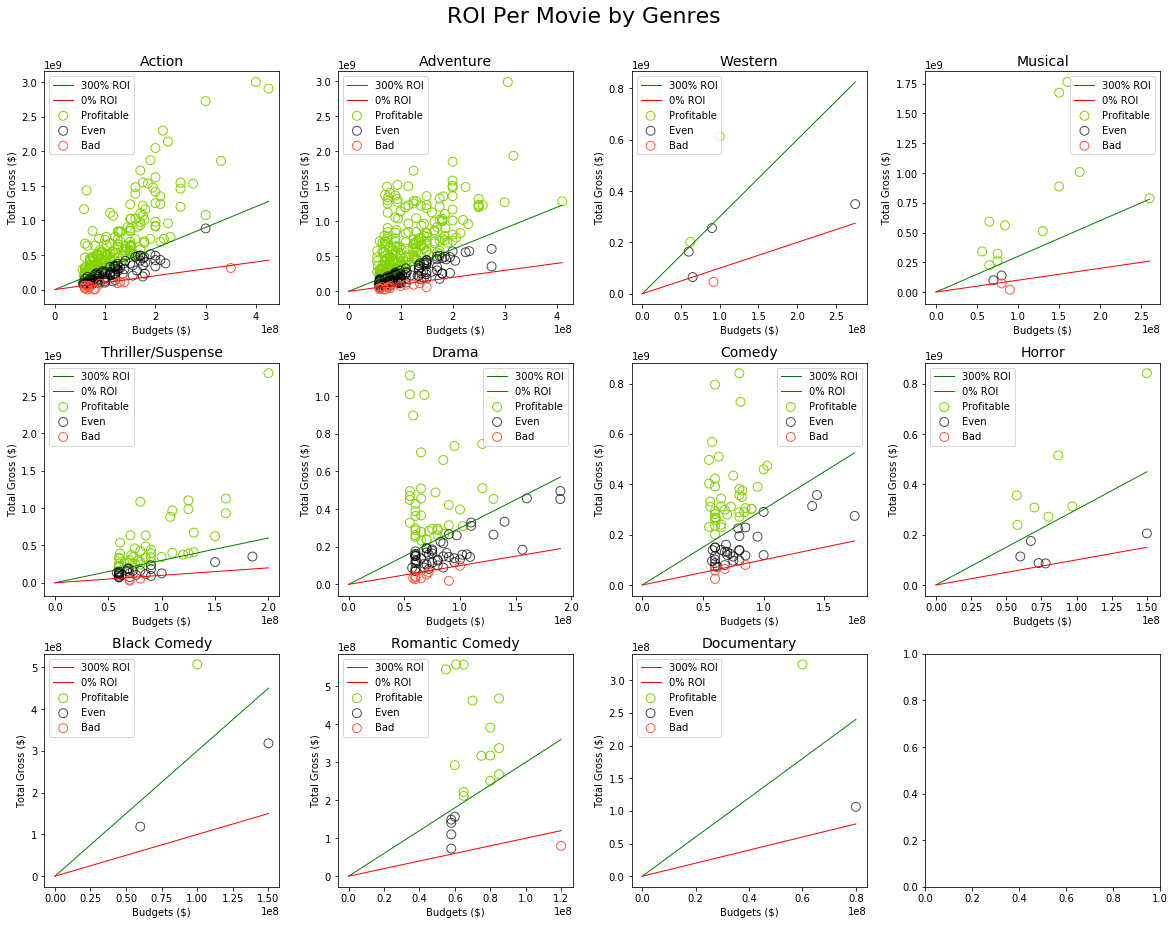

In [7]:
# cursor.execute("""SELECT movieGenre FROM movies ORDER BY (movieDomGross+movieIntGross-movieBudget) DESC;""")
# genres = cursor.fetchall()
# cursor.execute("""SELECT movieBudget FROM movies ORDER BY (movieDomGross+movieIntGross-movieBudget) DESC;""")
# budgets = cursor.fetchall()
# cursor.execute("""SELECT (movieDomGross+movieIntGross) FROM movies ORDER BY  (movieDomGross+movieIntGross-movieBudget) DESC;""")
# profits = cursor.fetchall()

fig, ax = plt.subplots(3,4,figsize = (20,15))
for i in range(len(genres_test)):
    genre = genres_test[i]
    curr_ax = ax[i//4][i%4]
#     ax.scatter(x=[boi[0] for boi in data[genre]],y=[gurl[0] for gurl in data[genre]],facecolors = None,edgecolors = colors[genre],s=80,label = genre)
    good_x = [x[0] for x in good_data[genre]]
    good_y = [y[1] for y in good_data[genre]]
    even_x = [x[0] for x in even_data[genre]]
    even_y = [y[1] for y in even_data[genre]]
    bad_x = [x[0] for x in bad_data[genre]]
    bad_y = [y[1] for y in bad_data[genre]]
    x = max(good_x+even_x+bad_x)
    y = max(good_y+even_y+bad_y)
    c = min(x,y)
    d = max(x,y)
    curr_ax.scatter(good_x,good_y,edgecolors = "#82d300",facecolors = 'none',label = 'Profitable',s=80,linewidth=1)
    curr_ax.scatter(even_x,even_y,edgecolors = "black",facecolors='none',label = 'Even',s=80,linewidth=1,alpha = 0.7)
    curr_ax.scatter(bad_x,bad_y,edgecolors = "#ff5a41",facecolors='none',label = 'Bad',s=80,linewidth=1)
    curr_ax.plot([0,c],[0,3*c],color='green',linewidth=1,label = '300% ROI')
    curr_ax.plot([0,c],[0,c],color='red',linewidth=1,label='0% ROI')
    curr_ax.axis('tight')
    curr_ax.set_title(genre,size=14)
    curr_ax.set_xlabel('Budgets ($)')
    curr_ax.set_ylabel('Total Gross ($)')
    curr_ax.legend()
    curr_ax.axis('tight')

# ax.set_xlabel('Budgets')
# ax.set_ylabel('Total Gross')
# ax.legend()
plt.subplots_adjust(wspace = 0.25, hspace = 0.25)
# plt.rcParams.update({'font.size':10})
plt.suptitle("ROI Per Movie by Genres",size=22,y=0.94)
plt.show()

In [8]:
query = """SELECT movieReleaseDate,movieDomGross,movieIntGross FROM movies ORDER BY movieReleaseDate DESC;"""
cursor.execute(query)
all_line_data = cursor.fetchall()
# all_line_data


In [9]:
release_years = list(set([date[0].year for date in all_line_data]))
domestic_gross = dict.fromkeys(release_years,0)
international_gross = dict.fromkeys(release_years,0)
for data in all_line_data:
    year = data[0].year
    domestic_gross[year] += data[1]
    international_gross[year] += data[2]
domestic_gross = [domestic_gross[year]/10**9 for year in release_years]
international_gross = [international_gross[year]/10**9 for year in release_years]

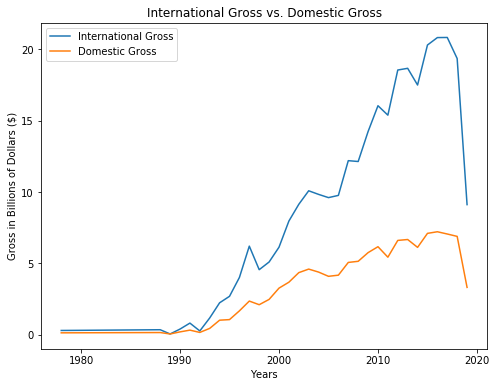

In [10]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(release_years,international_gross, label = "International Gross")
ax.plot(release_years,domestic_gross, label = 'Domestic Gross')
ax.axis('tight')
ax.set_xlabel('Years')
ax.set_ylabel('Gross in Billions of Dollars ($)')
ax.set_title('International Gross vs. Domestic Gross')
ax.legend()
plt.show()

In [11]:
query = """SELECT movieReleaseDate,movieType FROM movies ORDER BY movieReleaseDate DESC;"""
cursor.execute(query)
all_line_data = cursor.fetchall()
# all_line_data

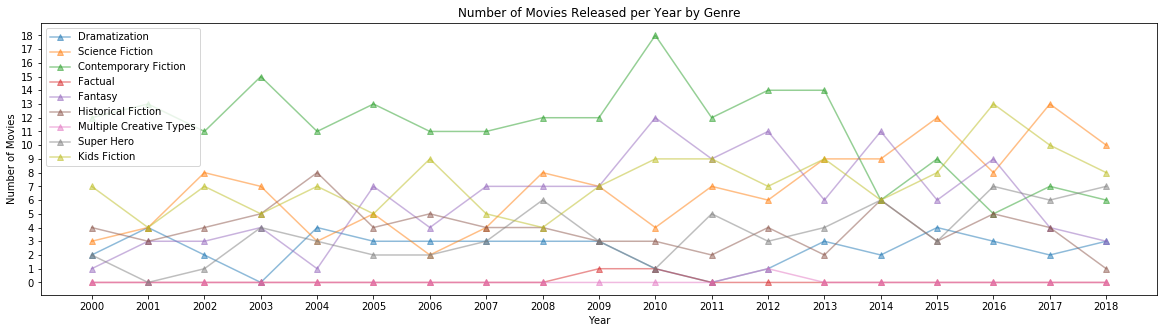

In [12]:
fig, ax = plt.subplots(figsize=(20,5))
movie_types = list(set([data[1] for data in all_line_data]))
store = []
for r_year in release_years:
    tracker = dict.fromkeys(movie_types,0)
    for data in all_line_data:
        if data[0].year == r_year:
            tracker[data[1]] += 1
    store.append(tracker)


for movie_type in movie_types:
    ax.plot(release_years[13:-1],[year[movie_type] for year in store[13:-1]],label = movie_type,marker = '^',alpha=0.5)
ax.set_xlabel('Year')
ax.set_ylabel("Number of Movies")
ax.set_title("Number of Movies Released per Year by Genre")
plt.xticks(release_years[13:-1])
plt.yticks(list(range(21)))
plt.legend()
# plt.grid()
ax.axis('tight')
ax.margins(x=2000)

In [13]:
close_connections()